## Import libraries

In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCS_emimTF2N_PR import configuration

## Create Model

In [2]:
# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [3]:
m.fs.F101 = Flash(default={"property_package": m.fs.props,
                               "has_heat_transfer": True,
                               "has_pressure_change": True})

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 8


In [4]:
## Update conditions to reduce DOF

# Fix Heater H101 inlet conditions
m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.5)
m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.001)

m.fs.F101.inlet.flow_mol[0].fix(1)
m.fs.F101.inlet.temperature.fix(300)
m.fs.F101.inlet.pressure.fix(200000)

# Fix F101 Flash outlet conditions
m.fs.F101.vap_outlet.temperature.fix(300)
m.fs.F101.deltaP.fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [5]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

## Calculate flash data

In [6]:
# Set pressures to loop over
P = [200000,300000,400000,500000,600000,700000,800000,900000,1000000]

# Set fraction of feed compositions of HFCs to loop over
HFC_feed_frac = [0.001,0.4,0.72,0.91,0.99]

# Make outlet arrays
IL_x = np.zeros((len(P),len(HFC_feed_frac)))
IL_y = np.zeros((len(P),len(HFC_feed_frac)))
R32_x = np.zeros((len(P),len(HFC_feed_frac)))
R32_y = np.zeros((len(P),len(HFC_feed_frac)))
R125_x = np.zeros((len(P),len(HFC_feed_frac)))
R125_y = np.zeros((len(P),len(HFC_feed_frac))) 

for i in range(len(P)):
    
    # Fix pressure
    m.fs.F101.inlet.pressure.fix(P[i])
    
    for j in range(len(HFC_feed_frac)):
        
        # Fix inlet mole fractions
        fract = 1 - HFC_feed_frac[j] 
        m.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.85*HFC_feed_frac[j])
        m.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.85*fract)
        m.fs.F101.inlet.mole_frac_comp[0, "emimTf2N"].fix(0.15)   

        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              

        # solve the model
        status = solver.solve(m, tee = False)
        # model.display()
        
        # If solution is optimal store the concentration, and calculated temperatures in the created arrays
        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            IL_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"])
            IL_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "emimTf2N"])
            R32_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
            R32_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
            R125_x[i,j] = value(m.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
            R125_y[i,j] = value(m.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])

            #Change this to feasible
            print("Running pressure:",P[i],"and HFC feed fraction",HFC_feed_frac[j])
#             print(value(m.fs.F101.liq_outlet.flow_mol[0]))
#             print(value(m.fs.F101.vap_outlet.flow_mol[0]))
        else:
            print('Infeasible.')

    

Running pressure: 200000 and HFC feed fraction 0.001
Running pressure: 200000 and HFC feed fraction 0.4
Running pressure: 200000 and HFC feed fraction 0.72
Running pressure: 200000 and HFC feed fraction 0.91
Running pressure: 200000 and HFC feed fraction 0.99
Running pressure: 300000 and HFC feed fraction 0.001
Running pressure: 300000 and HFC feed fraction 0.4
Running pressure: 300000 and HFC feed fraction 0.72
Running pressure: 300000 and HFC feed fraction 0.91
Running pressure: 300000 and HFC feed fraction 0.99
Running pressure: 400000 and HFC feed fraction 0.001
Running pressure: 400000 and HFC feed fraction 0.4
Running pressure: 400000 and HFC feed fraction 0.72
Running pressure: 400000 and HFC feed fraction 0.91
Running pressure: 400000 and HFC feed fraction 0.99
Running pressure: 500000 and HFC feed fraction 0.001
Running pressure: 500000 and HFC feed fraction 0.4
Running pressure: 500000 and HFC feed fraction 0.72
Running pressure: 500000 and HFC feed fraction 0.91
Running pres

In [7]:
print("IL_x =", IL_x)
print("IL_y =", IL_y)
print("R32_x =", R32_x)
print("R32_y =", R32_y)
print("R125_x =", R125_x)
print("R125_y =", R125_y)

IL_x = [[0.89584907 0.8660284  0.8422631  0.8282173  0.82231779]
 [0.84445679 0.80425553 0.77222876 0.75331452 0.74537425]
 [0.79334049 0.74570455 0.70762273 0.68510002 0.67563948]
 [0.74232734 0.69015875 0.64805216 0.6230303  0.61249708]
 [0.69119786 0.63737926 0.59310077 0.56653799 0.55530704]
 [0.63966299 0.58710271 0.54233946 0.51505241 0.50343126]
 [0.5873247  0.53903607 0.49533446 0.46801539 0.45625241]
 [0.53360347 0.49284646 0.45165184 0.42489137 0.41318581]
 [0.47759087 0.44814163 0.4108575  0.38517155 0.37368432]]
IL_y = [[1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
 [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]]
R32_x = [[1.85877788e-04 7.31341015e-02 1.29928061e-01 1.62952785e-01
  1.76706131e-01]
 [2.71666099e-04 1.06027848e-01 

In [8]:
IL_x = IL_x*100
IL_y = IL_y*100
R32_x = R32_x*100
R32_y = R32_y*100
R125_x = R125_x*100
R125_y = R125_y*100

In [9]:
points_x = []

for i in range(len(P)):
    for j in range(len(HFC_feed_frac)): #to shift how points are printed, shift the order
        points = (IL_x[i,j], R125_x[i,j], R32_x[i,j])
        points_x.append(points)

points 1 are: [(89.58490696982079, 10.396505251355167, 0.01858777882402739), (86.60283969347311, 6.083750159610686, 7.3134101469162065), (84.22630998778055, 2.780883929614499, 12.992806082604922), (82.82172968750929, 0.8829918178093387, 16.295278494678968), (82.23177907034089, 0.0976078590819454, 17.67061307057715)]
points 2 are: [(84.44567867093451, 15.527154719192682, 0.027166609872807692), (80.42555257194783, 8.971662603740262, 10.602784824311927), (77.2228763182374, 4.060235570316568, 18.716888111446035), (75.33145237134374, 1.2817151951061765, 23.38683243355007), (74.53742453999908, 0.1413393179120335, 25.32123614208889)]
points 3 are: [(79.33404923143041, 20.63068841013101, 0.035262358438565566), (74.57045511983884, 11.773808622592293, 13.655736257568865), (70.76227268379402, 5.277735878078122, 23.959991438127854), (68.51000162998102, 1.6569415707270516, 29.833056799291935), (67.56394836254785, 0.1823042818870356, 32.253747355565125)]
points 4 are: [(74.23273411720919, 25.7243975

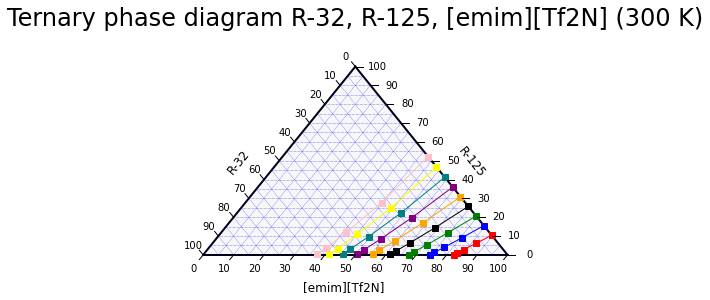

In [10]:
import ternary

scale = 100
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=2.0)
tax.gridlines(color="blue", multiple=5)

# Set Axis labels and Title
fontsize = 12
offset = 0.14
tax.set_title("Ternary phase diagram R-32, R-125, [emim][Tf2N] (300 K)\n", fontsize=24)
tax.left_axis_label("R-32", fontsize=fontsize, offset=offset)
tax.right_axis_label("R-125", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("[emim][Tf2N]", fontsize=fontsize, offset=offset)

color_options = ['red','blue','green','black','orange','purple','teal','yellow','pink']

for i in range(len(P)):
    color = color_options[i]
    i = i + 1
    print("points",i,"are:",points_x[5*i-5:5*i])
    tax.plot(points_x[5*i-5:5*i], marker='s', linewidth=1., color=color, linestyle="-")

tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()
# tax.savefig('emimTf2N_ternary_300K.pdf')